In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
source('../functions.R')
source('../parameters.sh')
source('parameters.sh')


In [3]:
devtools::load_all(multiSnpnet_src_d)


Loading multiSnpnet



In [5]:
# check if the config file has the correct lambda index
find_argmax_lambda_idx(file.path(RData_d, results_sub_d)) %>% print()
rdata_base %>% print()


[1] 92
[1] "output_lambda_92"


In [6]:
# read R Data file
load(file.path(RData_d, results_sub_d, paste0(rdata_base, '.RData')))


In [8]:
svd_C <- tsvd_of_C_with_names(fit, rank=rank)


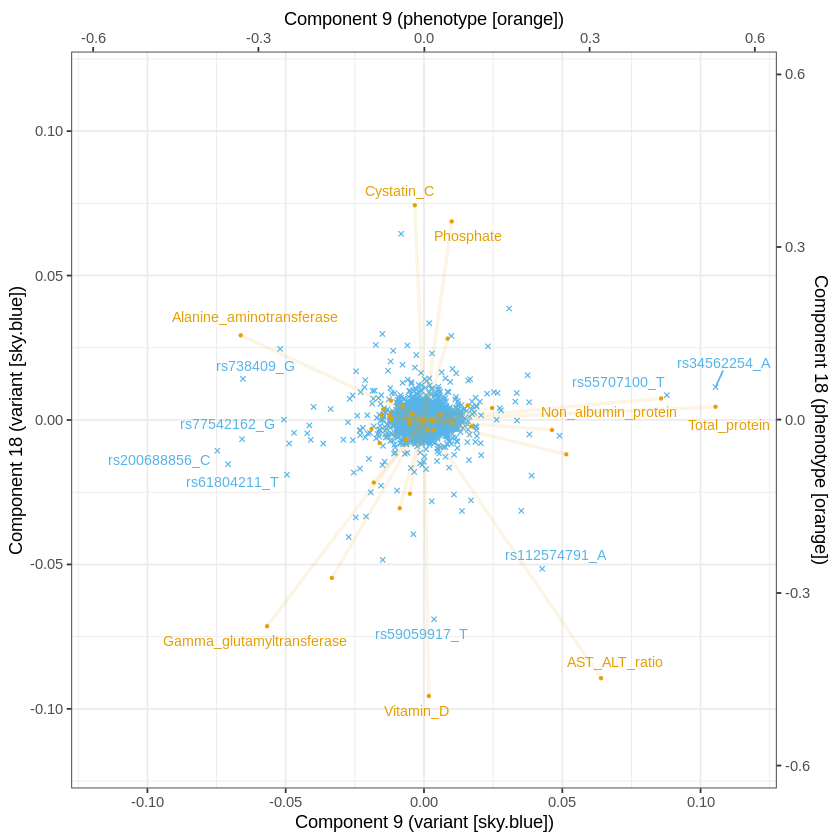

In [13]:
plot_biplot(
    svd_C, 
    component=list('x'=9, 'y'=18),
    label=list('phenotype'=rownames(svd_C$u), 'variant'=rownames(svd_C$v)),
    n_labels=list('phenotype'=8, 'variant'=8)
)


## save the SVD of C and scores

In [34]:
svd_C$u %>% as.data.frame %>%
rownames_to_column('rowname') %>%
rename('#rowname' = 'rowname') %>%
fwrite(
    file.path(RData_d, results_sub_d, sprintf('%s.svd.u.tsv', rdata_base)),
    sep='\t', na = "NA", quote=F
)

svd_C$v %>% as.data.frame %>%
rownames_to_column('rowname') %>%
rename('#rowname' = 'rowname') %>%
fwrite(
    file.path(RData_d, results_sub_d, sprintf('%s.svd.v.tsv', rdata_base)),
    sep='\t', na = "NA", quote=F
)

svd_C$d %>% as.data.frame %>%
rename('d'=1) %>%
rownames_to_column('rowname') %>%
rename('#rowname' = 'rowname') %>%
fwrite(
    file.path(RData_d, results_sub_d, sprintf('%s.svd.d.tsv', rdata_base)),
    sep='\t', na = "NA", quote=F
)


In [35]:
svd_C %>%
score_contribution %>%
rename('#rowname' = 'rowname') %>%
fwrite(
    file.path(RData_d, results_sub_d, sprintf('%s.score_contribution.tsv', rdata_base)),
    sep='\t', na = "NA", quote=F
)

svd_C %>%
score_squared_cosine %>%
rename('#rowname' = 'rowname') %>%
fwrite(
    file.path(RData_d, results_sub_d, sprintf('%s.score_squared_cosine.tsv', rdata_base)),
    sep='\t', na = "NA", quote=F
)


## Trait contribution score

In [14]:
svd_C %>% score_contribution() %>%
mutate(component = str_replace(component, '^Component', '')) %>%
mutate(component_order = as.integer(component)) %>%
mutate(rowname = str_replace(rowname, '_adjstatins', '')) %>%
mutate(rowname = str_replace(rowname, '_adjstatin', '')) %>%
mutate(rowname = str_replace_all(rowname, '_', ' ')) %>%
ggplot(aes(fill=rowname, y=contribution_score, x=reorder(component, component_order))) + 
geom_bar(position="stack", stat="identity", color='black') +
theme_bw(base_size=16) +
# theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
theme(legend.position='bottom') +
labs(
    x = 'Component',
    y = 'Phenotype contribution score\n(Relative importance of phenotype to each component)',
    fill=''
) + guides(fill=guide_legend(ncol=3)) -> p_contribution


In [9]:
ggsave('contribution.pdf', p_contribution, width=16, height=16)


## Importance of the components (scree plot and trait squared cosine score)


In [16]:
svd_C %>% score_squared_cosine() %>%
bind_rows(
    ((svd_C$d ** 2) / sum(svd_C$d ** 2) ) %>%
    enframe(name = 'component', value='squared_cosine_score') %>%
    mutate(rowname = '(all traits combined)')
) %>%
mutate(rowname = str_replace(rowname, '_adjstatins', '')) %>%
mutate(rowname = str_replace(rowname, '_adjstatin', '')) %>%
mutate(rowname = str_replace_all(rowname, '_', ' ')) %>%
mutate(component_order=as.numeric(str_replace_all(component, '^Component', ''))) %>%
ggplot(aes(fill=reorder(component, component_order), y=squared_cosine_score, x=rowname)) + 
geom_bar(position="stack", stat="identity", color='black') +
theme_bw(base_size=16) +
coord_flip() + scale_y_reverse() +
theme(legend.position='bottom') +
labs(x = 'Phenotype', y = 'Relative importance of the components for each phenotype', fill='') -> p_squared_cosine


In [11]:
ggsave('squared_cosine.pdf', p_squared_cosine, width=16, height=16)


In [18]:
svd_C %>% score_squared_cosine() %>% 
filter(rowname == 'AST_ALT_ratio') %>%
arrange(-squared_cosine_score) %>%
head(5)


,rowname,component,squared_cosine_score
,<chr>,<chr>,<dbl>
1,AST_ALT_ratio,Component9,0.20262831
2,AST_ALT_ratio,Component18,0.16102610
3,AST_ALT_ratio,Component20,0.15437741
4,AST_ALT_ratio,Component8,0.13557293
5,AST_ALT_ratio,Component3,0.09199192


In [41]:
svd_C %>% score_contribution() %>%
left_join(   
    svd_C %>% score_squared_cosine() %>% 
    filter(rowname == 'AST_ALT_ratio') %>%
    select(-rowname),
    by='component'
) %>%
mutate(contribution_score_scaled = contribution_score * squared_cosine_score) %>%
mutate(component = str_replace(component, '^Component', '')) %>%
filter(component %in% c(9, 18, 20, 8, 3)) %>%
left_join(
    data.frame(
        component = c('9', '18', '20', '8', '3'),
        component_order = 1:5,
        stringsAsFactors=F
    ),
    by='component'
) %>%
mutate(rowname = str_replace(rowname, '_adjstatins', '')) %>%
mutate(rowname = str_replace(rowname, '_adjstatin', '')) %>%
mutate(rowname = str_replace_all(rowname, '_', ' ')) %>%
ggplot(aes(fill=rowname, y=contribution_score_scaled, x=reorder(component, component_order))) + 
geom_bar(position="stack", stat="identity", color='black') +
theme_bw(base_size=16) +
# theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
theme(legend.position='bottom') +
labs(
    x = 'Component',
    y = 'Relative importance of components for AST/ALT ratio (sum)\n(Relative importance of phenotype to each component)',
    fill=''
) + guides(fill=guide_legend(ncol=3)) -> p_contribution_AST_ALT_ratio


In [42]:
ggsave('contribution_AST_ALT_ratio.pdf', p_contribution_AST_ALT_ratio, width=10, height=10)


In [46]:
svd_C %>% score_contribution() %>%
filter(component == 'Component9') %>%
arrange(-contribution_score) %>% head()

,rowname,component,contribution_score
,<chr>,<chr>,<dbl>
1,Total_protein,Component9,0.27992013
2,Non_albumin_protein,Component9,0.18525844
3,Alanine_aminotransferase,Component9,0.11069258
4,AST_ALT_ratio,Component9,0.10321124
5,Gamma_glutamyltransferase,Component9,0.08112381
6,Calcium,Component9,0.06670346


In [47]:
svd_C %>% score_contribution() %>%
filter(component == 'Component18') %>%
arrange(-contribution_score) %>% head()

,rowname,component,contribution_score
,<chr>,<chr>,<dbl>
1,Vitamin_D,Component18,0.23007735
2,AST_ALT_ratio,Component18,0.20129085
3,Cystatin_C,Component18,0.13926361
4,Gamma_glutamyltransferase,Component18,0.12836965
5,Phosphate,Component18,0.11913819
6,Aspartate_aminotransferase,Component18,0.07530415


In [48]:
svd_C %>% score_contribution() %>%
filter(component == 'Component20') %>%
arrange(-contribution_score) %>% head()

,rowname,component,contribution_score
,<chr>,<chr>,<dbl>
1,AST_ALT_ratio,Component20,0.23472777
2,Vitamin_D,Component20,0.22017735
3,Aspartate_aminotransferase,Component20,0.14136644
4,Cystatin_C,Component20,0.11034654
5,IGF_1,Component20,0.05491441
6,Potassium_in_urine,Component20,0.02891174


## variant contribution score

In [15]:
svd_C %>% score_contribution(right_singular_vectors = T) %>%
filter(contribution_score > 0) %>%
group_by(component) %>%
arrange(-contribution_score) %>%
mutate(
    rank = rank(-contribution_score), cum_sum = cumsum(contribution_score)
) -> var_contribution_df



In [22]:
var_contribution_df %>%
mutate(component_idx = as.integer(str_replace(component, '^Component', ''))) %>%
group_by(component) %>% mutate(row_idx = 1:n()) %>%
filter(contribution_score > 1e-4 | rank <= 5000 | row_idx %% 50 == 0) %>%
# do not plot all the points at the tail of the distribution so that
# to speed up the rendering
ggplot(aes(x = rank, y = cum_sum)) + 
geom_point() + facet_wrap( ~ reorder(component, component_idx), ncol=6) +
theme_bw(base_size=16) + ylim(0, 1) -> p_var_contribution_cumsum


In [23]:
ggsave('var_contribution_cumsum.pdf', p_var_contribution_cumsum, width=24, height=24)


In [51]:
var_contribution_df %>% 
filter(component == 'Component9') %>%
arrange(-contribution_score) %>% head(3) %>%
left_join(
    var_annot_df %>% select(SYMBOL, ID_ALT, Csq),
    by=c('rowname'='ID_ALT')
)

rowname,component,contribution_score,rank,cum_sum,SYMBOL,Csq
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
rs34562254_A,Component9,0.04372445,1,0.04372445,TNFRSF13B,pav
rs55707100_T,Component9,0.03031716,2,0.07404160,MAP1A,pav
rs200688856_C,Component9,0.02197437,3,0.09601598,FCGR3B,pav


In [52]:
var_contribution_df %>% 
filter(component == 'Component18') %>%
arrange(-contribution_score) %>% head(3) %>%
left_join(
    var_annot_df %>% select(SYMBOL, ID_ALT, Csq),
    by=c('rowname'='ID_ALT')
)

rowname,component,contribution_score,rank,cum_sum,SYMBOL,Csq
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
rs59059917_T,Component18,0.04596428,1,0.04596428,NA,others
rs4588_T,Component18,0.04010944,2,0.08607372,GC,pav
rs112574791_A,Component18,0.02561601,3,0.11168974,GPT,pav


In [73]:
fit$C %>% as.matrix() %>% as.data.frame() %>%
rownames_to_column() %>%
filter(rowname == 'rs34562254_A') %>%
gather(trait, beta, -rowname) %>%
filter(trait %in% c('AST_ALT_ratio', 'Total_protein', 'Non_albumin_protein'))

rowname,trait,beta
<chr>,<chr>,<dbl>
rs34562254_A,Total_protein,0.093918203
rs34562254_A,Non_albumin_protein,0.123055938
rs34562254_A,AST_ALT_ratio,0.004062235


In [74]:
fit$C %>% as.matrix() %>% as.data.frame() %>%
rownames_to_column() %>%
filter(rowname == 'rs4588_T') %>%
gather(trait, beta, -rowname) %>%
filter(trait %in% c('AST_ALT_ratio', 'Vitamin_D'))

rowname,trait,beta
<chr>,<chr>,<dbl>
rs4588_T,Vitamin_D,-0.14386322
rs4588_T,AST_ALT_ratio,0.00384196


In [78]:
var_contribution_df %>% 
filter(component %in% c('Component9', 'Component18', 'Component20')) %>%
filter(rowname == 'rs4588_T') %>%
left_join(
    var_annot_df %>% select(SYMBOL, ID_ALT, Csq),
    by=c('rowname'='ID_ALT')
)

rowname,component,contribution_score,rank,cum_sum,SYMBOL,Csq
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
rs4588_T,Component20,0.0604104518,1,0.06041045,GC,pav
rs4588_T,Component18,0.0401094427,2,0.08607372,GC,pav
rs4588_T,Component9,0.0002683888,385,0.55130168,GC,pav


In [65]:
fit$C %>% as.matrix() %>% as.data.frame() %>%
rownames_to_column() %>%
filter(rowname == 'rs59059917_T') %>%
gather(trait, beta, -rowname) %>%
filter(trait %in% c('AST_ALT_ratio', 'Vitamin_D'))

rowname,trait,beta
<chr>,<chr>,<dbl>
rs59059917_T,Vitamin_D,-0.004187578
rs59059917_T,AST_ALT_ratio,0.004777884


In [63]:
fit$C %>% as.matrix() %>% as.data.frame() %>%
rownames_to_column() %>%
filter(rowname == 'rs112574791_A') %>%
gather(trait, beta, -rowname) %>%
filter(trait %in% c('AST_ALT_ratio', 'Alanine_aminotransferase'))

rowname,trait,beta
<chr>,<chr>,<dbl>
rs112574791_A,Alanine_aminotransferase,-0.06258911
rs112574791_A,AST_ALT_ratio,0.08763039


## prepare input files for GREAT enrichment

In [24]:
# read variant annotation files
var_annot_f %>%
read_var_annot() %>%
filter(
    ID_ALT %in% rownames(fit$C)
) -> var_annot_df


In [25]:
var_annot_df %>% dim()


[1] 32254    30

In [26]:
d_GREAT_in <- file.path(data_d, results_sub_d, rdata_base, 'GREAT', '1_in_bed')


In [27]:
mkdir_p_if_not_exist(d_GREAT_in)


In [29]:
mkdir_p_if_not_exist(file.path(dirname(d_GREAT_in), '3_out_by_onto'))


In [28]:
for(component_idx in 1:rank){
    var_annot_df %>% 
    filter(ID_ALT %in% get_top_k_variants(var_contribution_df, component_idx)) %>% 
    select(CHROM, POS, POS_e, ID) %>%
    fwrite(file.path(d_GREAT_in, paste0(component_idx, '.bed')), sep='\t', na = "NA", quote=F, col.names=F)    
}
